In [64]:
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.linear_model import LinearRegression

In [65]:
def detect_circle(path: str, max_min_radius: tuple,two_filters: tuple, plot_image=False, save_name=None):
    original_pil = Image.open(path)
    gray_pil = original_pil.convert("L")
    gray = np.array(gray_pil)

    gray_blur = cv2.GaussianBlur(gray, (9, 9), 2)

    circles = cv2.HoughCircles(
        gray_blur,
        cv2.HOUGH_GRADIENT,
        dp=1.2,
        minDist=100,
        param1=100,
        param2=30,
        minRadius=max_min_radius[0],
        maxRadius=max_min_radius[1]
    )

    frame = cv2.cvtColor(np.array(Image.open(path)), cv2.COLOR_RGB2BGR)

    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        circles = sorted(circles, key=lambda x: x[2], reverse=True)

        x, y, r = circles[0]
        cv2.circle(frame, (x, y), r, (0, 255, 0), 4)
        n = 18
        r_reduced = max(1, r - n)
        cv2.circle(frame, (x, y), r_reduced, (255, 0, 255), 2)

        mask = np.zeros_like(gray)
        cv2.circle(mask, (x, y), r_reduced, (255, 255, 255), -1)
        masked = cv2.bitwise_and(gray, mask)

    ys, xs = np.where(masked > 0)
    intensities = masked[ys, xs]
    X = np.column_stack((xs, ys))
    y = intensities
    model = LinearRegression().fit(X, y)
    a, b = model.coef_
    c = model.intercept_
    gradient_image = np.zeros_like(masked, dtype=np.float32)
    for x, y in zip(xs, ys):
        gradient_image[y, x] = a * x + b * y + c

    no_grad = masked - gradient_image
    no_grad_uint8 = np.clip(no_grad, 0, 255).astype(np.uint8)
    no_grad_norm = cv2.bitwise_and(no_grad_uint8, mask)
    no_grad_norm = np.clip(no_grad_norm, 0, 255)


    filter1 = (no_grad_norm > two_filters[0])*255
    coved_area1 = np.count_nonzero(filter1) / np.count_nonzero(masked)

    filter2 = (masked > two_filters[1])*255
    coved_area2 = np.count_nonzero(filter2) / np.count_nonzero(masked)

    fig = plt.figure(figsize=(15, 6))
    gs = plt.GridSpec(2, 3, height_ratios=[1, 1])

    ax1 = fig.add_subplot(gs[0, 0])
    im1 = ax1.imshow(frame)
    fig.colorbar(im1, ax=ax1)

    ax2 = fig.add_subplot(gs[0, 1])
    im2 = ax2.imshow(masked, cmap='gray',vmin=0, vmax=255)
    fig.colorbar(im2, ax=ax2)

    ax3 = fig.add_subplot(gs[0, 2])
    im3 = ax3.imshow(gradient_image, cmap='gray', vmin=0, vmax=255)
    fig.colorbar(im3, ax=ax3)

    ax4 = fig.add_subplot(gs[1, 0])
    im4 = ax4.imshow(filter1, cmap='gray',vmin=0, vmax=255)
    fig.colorbar(im4, ax=ax4)

    ax5 = fig.add_subplot(gs[1, 1])
    im5 = ax5.imshow(no_grad_norm, cmap='gray',vmin=0, vmax=255)
    fig.colorbar(im5, ax=ax5)

    ax6 = fig.add_subplot(gs[1, 2])
    im6 = ax6.imshow(filter2, cmap='gray',vmin=0, vmax=255)
    fig.colorbar(im6, ax=ax6)

    if save_name is not None:
        fig.savefig(save_name)

    if plot_image:
        plt.show()
    else:
        plt.close(fig)


    return coved_area1,coved_area2,no_grad_norm,masked


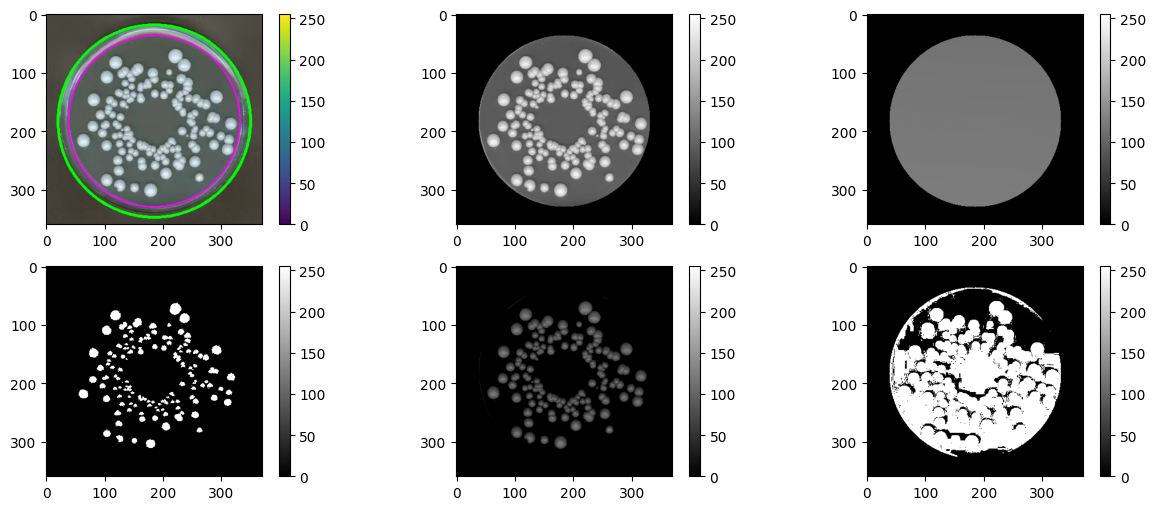

In [72]:
coved_area1,coved_area2,no_grad_norm,masked = detect_circle("placa real.jpg", (100,210),(77,90),plot_image=True,save_name='a.png')

In [74]:
coved_area1,coved_area2

(0.11453497796837467, 0.703184638283449)

In [68]:
porcentagens = []
porcentagens2 = []

valor_i = []



for i in range(0,255):
   filter1 = (no_grad_norm > i)*255
   filter2 = (masked > i)*255
   coved_area1 = np.count_nonzero(filter1) / np.count_nonzero(masked)
   coved_area2 = np.count_nonzero(filter2) / np.count_nonzero(masked)
   porcentagens.append(coved_area1)
   porcentagens2.append(coved_area2)

   valor_i.append(i)
   print(i,end='\r')
   


In [69]:
dp_di = [porcentagens[i]-porcentagens[i+1] for i in range(len(porcentagens)-1)]

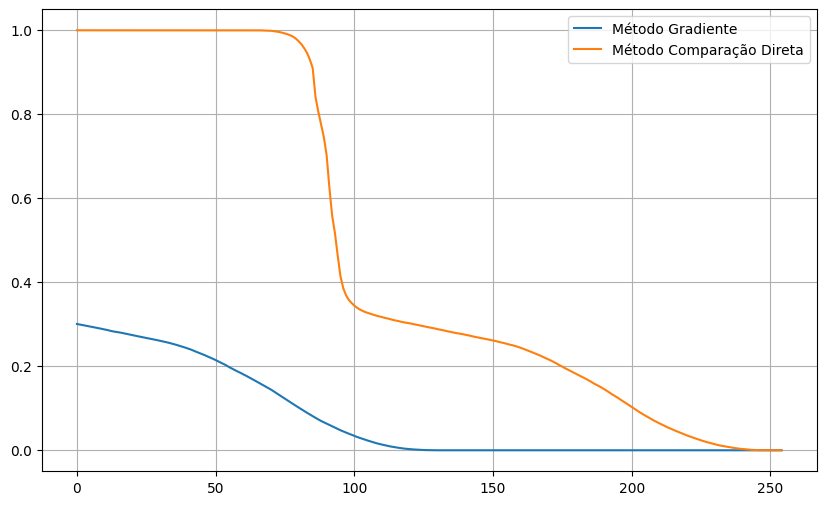

In [70]:
plt.figure(figsize=(10,6))
plt.grid()
plt.plot(valor_i,porcentagens,label=f'Método Gradiente')
plt.plot(valor_i,porcentagens2,label = f'Método Comparação Direta')
plt.legend()


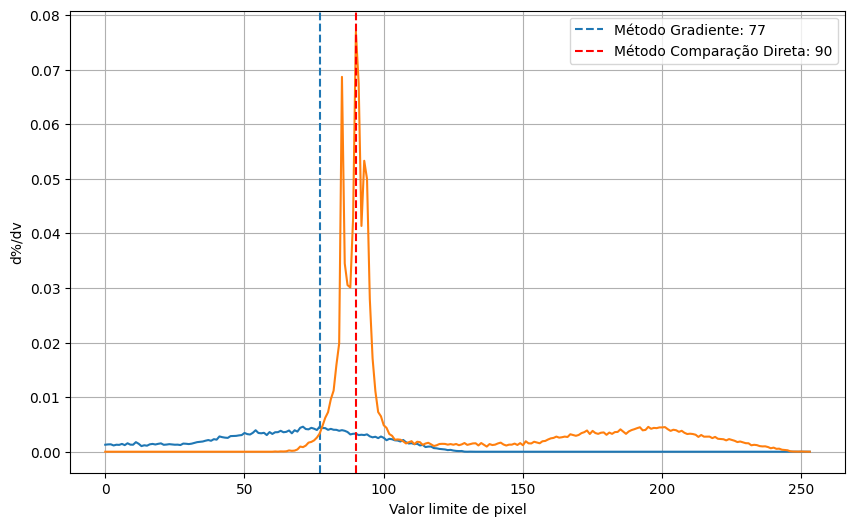

In [71]:
dp_di = np.array([porcentagens[i]-porcentagens[i+1] for i in range(len(porcentagens)-1)])
dp2_di = np.array([porcentagens2[i]-porcentagens2[i+1] for i in range(len(porcentagens2)-1)])


max_dp = dp_di.argmax()
max_dp2 = dp2_di.argmax()

plt.figure(figsize=(10,6))
plt.grid()
plt.plot(valor_i[:-1],dp_di)
plt.axvline(max_dp, label=f'Método Gradiente: {max_dp}',linestyle='--')
plt.plot(valor_i[:-1],dp2_di)
plt.axvline(max_dp2, label=f'Método Comparação Direta: {max_dp2}',linestyle='--', color='red')
plt.xlabel("Valor limite de pixel")
plt.ylabel("d%/dv")
plt.legend()
